In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn.functional as F
from beartype import beartype as typed
from torch import Tensor as TT
from jaxtyping import Float, Int
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


 ## English (TinyStories)

In [2]:
dataset = load_dataset("roneneldan/TinyStories", streaming=True)
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
tokenizer = AutoTokenizer.from_pretrained("roneneldan/TinyStories-8M")
tokenizer.pad_token = tokenizer.eos_token
all_tokens = [tokenizer.decode([i]) for i in range(len(tokenizer))]


Repo card metadata block was not found. Setting CardData to empty.


In [3]:
get_model = lambda name: AutoModelForCausalLM.from_pretrained(name)
big = get_model("roneneldan/TinyStories-33M")
from_scratch = get_model("roneneldan/TinyStories-8M")
from_nested_emb = get_model("Mlxa/embeddings-nested-english")
from_nested_tun = get_model("Mlxa/tuned-nested-english")
from_flat_emb = get_model("Mlxa/embeddings-flat-english")
from_flat_tun = get_model("Mlxa/tuned-flat-english")
from_shuffle_emb = get_model("Mlxa/embeddings-flat_shuffle-english")
from_shuffle_tun = get_model("Mlxa/tuned-flat_shuffle-english")


 ### Word-level information

In [4]:
import pandas as pd
features = pd.read_csv("word_features.csv", escapechar="\\")
features["frequency"] = features["frequency"].astype(float).apply(np.log1p)
features = pd.get_dummies(features, columns=["pos_tag"])
to_remove = [c for c in features.columns if (features[c] != False).sum() < 200]
features = features.drop(to_remove, axis=1)


In [5]:
get_embeddings = lambda model: model.get_input_embeddings().weight.detach()

emb_dict = {
    "scratch": get_embeddings(from_scratch),
    "nested": get_embeddings(from_nested_tun),
    "flat": get_embeddings(from_flat_emb),
    "shuffle": get_embeddings(from_shuffle_emb),
}


scratch 86.72960662841797
nested 16.442638397216797
flat 21.503097534179688
shuffle 24.196727752685547


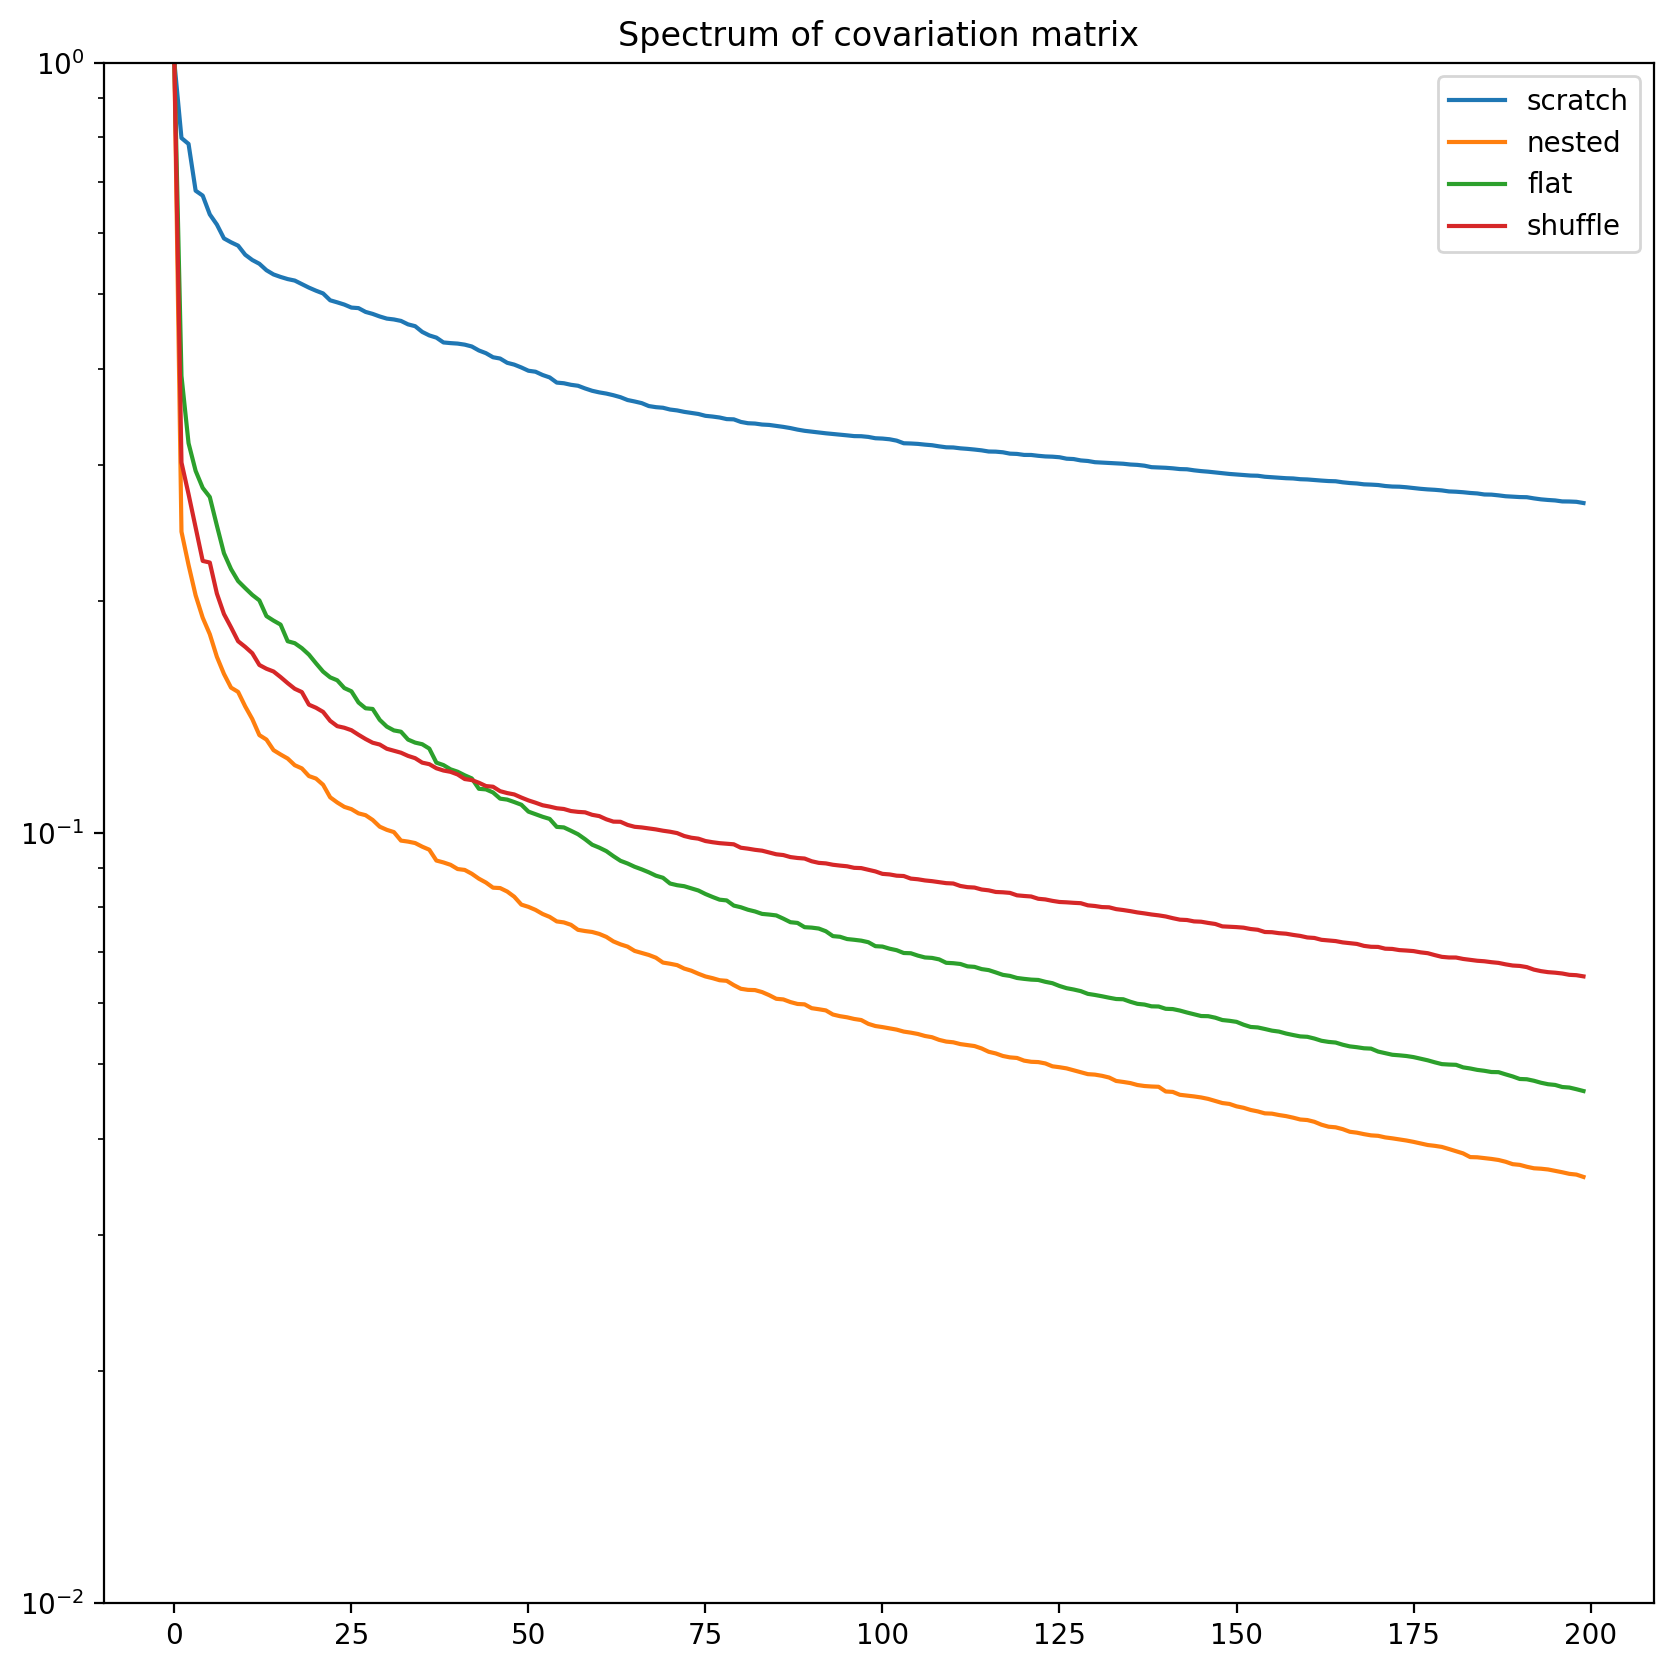

In [6]:
from utils import spectrum

plt.figure(figsize=(10, 10), dpi=200)
plt.title("Spectrum of covariation matrix")
for name, emb in emb_dict.items():
    sp = spectrum(emb)
    print(name, sp.sum().item())
    plt.plot(sp[:200], label=name)
plt.yscale("log")
plt.ylim(0.01, 1)
plt.legend()
plt.savefig(f"img/spectrum.svg")


In [7]:
from utils import clusters

plt.figure(figsize=(10, 10), dpi=200)
plt.title("Inertia of KMeans")
for name, emb in emb_dict.items():
    print(name)
    plt.plot(clusters(emb, max_clusters=100), label=name)
plt.yscale("log")
plt.ylim(0.1, 1)
plt.legend()
plt.savefig(f"img/clusters.svg")


In [8]:
from utils import singular_vectors
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

def analyze(name, n_vectors: int = 5, n_clusters: int = 10):
    emb = emb_dict[name]
    vecs = singular_vectors(emb)
    print("Singular vectors:", name)
    for i, v in enumerate(vecs[:n_vectors]):
        proj = emb @ v
        order = t.argsort(proj)

        print(f"#{i}, low:", [all_tokens[id] for id in order[:100:10]])
        print(f"#{i}, high:", [all_tokens[id] for id in order[-100::10]])
        plt.title("Distribution along this vector")
        plt.plot(proj.numpy(), t.randn_like(proj).numpy(), "x")
        plt.show()
        plt.clf()
    kmeans = KMeans(n_clusters=n_clusters, n_init=10).fit(emb)
    labels = kmeans.labels_
    step = 100
    tsne = TSNE(n_components=2).fit(emb[::step]).embedding_
    for i in range(n_clusters):
        plt.plot(tsne[labels[::step] == i, 0], tsne[labels[::step] == i, 1], "x", label=f"#{i}")
    plt.legend()
    plt.show()
    plt.clf()
    for i in range(n_clusters):
        sample = [all_tokens[id] for id in t.randperm(len(all_tokens)) if labels[id] == i][:10]
        print(f"#{i}:", sample)


In [9]:
def analyze_probe(name):
    from utils import mixed_probe
    return mixed_probe(emb_dict[name], features.drop(columns=["id", "token"]))


In [10]:
import json
names = ["scratch", "nested", "flat", "shuffle"]
results = { name : analyze_probe(name) for name in names }
print(json.dumps(results, indent=2))


{
  "scratch": {
    "frequency": 0.9248593057417246,
    "start_space": 0.8910188181049081,
    "pos_tag_CD": 0.7992568868702715,
    "pos_tag_IN": 0.8732190656731874,
    "pos_tag_JJ": 0.7275158821199675,
    "pos_tag_NN": 0.7622660235218229,
    "pos_tag_NNP": 0.7915061461879855,
    "pos_tag_NNS": 0.8376227034291788,
    "pos_tag_RB": 0.8371648993369586,
    "pos_tag_VB": 0.7937981235806905,
    "pos_tag_VBD": 0.8856657287219698,
    "pos_tag_VBG": 0.8908151355250861,
    "pos_tag_VBN": 0.8663044074208137
  },
  "nested": {
    "frequency": 0.8393035511422327,
    "start_space": 0.7004694496567394,
    "pos_tag_CD": 0.6578859702725856,
    "pos_tag_IN": 0.762512835365051,
    "pos_tag_JJ": 0.5971608691322436,
    "pos_tag_NN": 0.6300643535678923,
    "pos_tag_NNP": 0.6447501430569988,
    "pos_tag_NNS": 0.6663525763013298,
    "pos_tag_RB": 0.6946884642334135,
    "pos_tag_VB": 0.7109956527887052,
    "pos_tag_VBD": 0.7500945577158249,
    "pos_tag_VBG": 0.705627104109763,
    "pos

In [11]:
from utils import cloze_test
from tqdm import tqdm
import json

with open("cloze_tasks.json") as f:
    tasks = json.load(f)

def analyze_cloze(model):
    results = {}
    for task_name, prompts in tasks.items():
        results[task_name] = cloze_test(model, tokenizer, prompts).mean().item()
    return results


In [12]:
models_dict = {
    "nested ELT": from_nested_tun,
    "nested E": from_nested_emb,
    "flat ELT": from_flat_tun,
    "flat E": from_flat_emb,
    "shuffle ELT": from_shuffle_tun,
    "shuffle E": from_shuffle_emb,
    "scratch 8M": from_scratch,
    "scratch 33M": big,
}
results = {}
for name, model in tqdm(models_dict.items()):
    results[name] = analyze_cloze(model)
print(json.dumps(results, indent=2))

100%|██████████| 8/8 [00:59<00:00,  7.46s/it]

{
  "nested ELT": {
    "synonyms and antonyms": 0.17702293395996094,
    "single plural": 0.14714451134204865,
    "logical relations": -0.295958936214447,
    "subject verb agreement": 0.4473360478878021,
    "prepositions": 0.5159503817558289,
    "conjunctions": 0.4349181056022644,
    "temporal understanding": -0.0218979362398386,
    "spatial understanding": 0.30221208930015564,
    "quantitative reasoning": 0.003439998719841242,
    "emotions": 0.03421132639050484,
    "narrative understanding": -0.038889504969120026,
    "ethics": 0.17342376708984375
  },
  "nested E": {
    "synonyms and antonyms": 0.2430839091539383,
    "single plural": 0.08304605633020401,
    "logical relations": -0.07686467468738556,
    "subject verb agreement": 0.5402786135673523,
    "prepositions": 0.42600518465042114,
    "conjunctions": 0.4638051986694336,
    "temporal understanding": -0.13114333152770996,
    "spatial understanding": 0.1329100877046585,
    "quantitative reasoning": -0.05629243701